# Scan of AIC to fix C and constrain ka/k2 (if necessary)

In [2]:
#Libraries
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, Parameter, fit_report

In [3]:
#Functions
def residual(pars, x, data=None):
    C = pars['C']
    ka = pars['ka']
    k2 = pars['k2']
    model = C*(-np.exp(-ka*x) + np.exp(-k2*x))
    if data is None:
        return model

    return model - data

def One_Elimination(x, C, ka, k2):
    return C*(-np.exp(-ka*x) + np.exp(-k2*x))

## AIC scans

In [45]:
#Fitting of random curves

C_vector = []
ka_vector = []
k2_vector = []
AIC_vector = []

n=1000 #change here the number of random simulations
#print(n)

for i in range(0,n):
    x_values = np.array([0, 5, 15, 30, 60])
        
    selection = 0 #Select 1 to use real means, or 0 to use random integers based on normal distribution of time points
    if selection == 0:
        #In this section, the mean of all animals is entered per time point, together with the standard deviation
        t0 = 0 
        t5 = np.random.normal(0.038, 0.02)
        t15 = np.random.normal(0.048, 0.03)
        t30 = np.random.normal(0.034, 0.02)
        t60 = np.random.normal(0.010, 0.01)
        y_values = np.array([t0,t5, t15, t30, t60]) #random values following normal distribution
    else:
        y_values = np.array([0, 0.038, 0.048,0.034,0.010]) # real mean
            
    #Initial guess for parameters
    C_=0.001*i #screens a range of C values (adapt according to dataset)
    # C_ = 1
    ka_=0.1
    k2_=0.01

   # set parameters including bounds; you can also fix parameters (use vary=False)
    params = Parameters()
    params.add('C', value=C_, vary = False) 
    params.add('ka', value=ka_, min = 0, max = np.inf) 
    params.add('k2', value=k2_, min = 0, max = np.inf) 

    result = minimize(residual, params, args=(x_values, y_values), method='leastsq') 

    show = 0 # show=0 do not show plots and report, show=1 show plots for each randomly generated curve
    if show == 1:
        data_fitted = One_Elimination(np.linspace(0, 180, 181), result.params['C'].value,result.params['ka'].value,result.params['k2'].value)
        plt.figure()
        plt.scatter(x_values, y_values, marker='.', label='data')
        plt.plot(np.linspace(0, 180, 181), data_fitted, color = 'orange', label='fit')
        plt.xlabel('Time')
        plt.ylabel('Tracer')
        plt.legend()
        plt.show()
        print(fit_report(result))
    
    C_vector.append(result.params['C'].value)
    ka_vector.append(result.params['ka'].value)
    k2_vector.append(result.params['k2'].value)
    AIC_vector.append(result.aic)


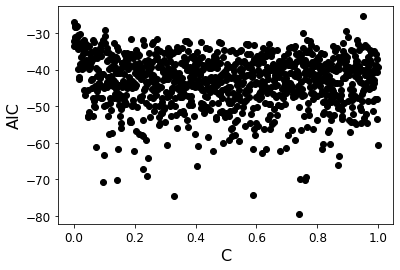

In [46]:
#Plot AIC vs C (random or mean-based)

fig2, ax = plt.subplots(1)
ax.plot(C_vector, AIC_vector, 'o', color='black')
ax.set_xlabel('C', fontsize=16)
ax.set_ylabel('AIC', fontsize=16)
#ax.set_title('%s scan')
plt.rcParams['font.size'] = '16'
# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)
fig2.savefig('AIC vs C v3.png', dpi=600, bbox_inches='tight')

## Correlations between ka and k2

In [48]:

C_vector = []
ka_vector = []
k2_vector = []
AIC_vector = []

n=500 #change here the number of random simulations
#print(n)

for i in range(0,n):
    x_values = np.array([0, 5, 15, 30, 60])
        
    selection = 0 #Select 1 to use real means, or 0 to use random integers based on normal distribution of time points
    if selection == 0:
        #In this section, the mean of all animals is entered per time point, together with the standard deviation
        t0 = 0 
        t5 = np.random.normal(0.038, 0.02)
        t15 = np.random.normal(0.048, 0.03)
        t30 = np.random.normal(0.034, 0.02)
        t60 = np.random.normal(0.010, 0.01)
        y_values = np.array([t0,t5, t15, t30, t60]) #random values following normal distribution
    else:
        y_values = np.array([0, 0.038, 0.048,0.034,0.010]) # real mean
            
   
    #Initial guess for parameters

    C_options = [0.025,0.05,0.075,0.1,0.125,0.15,0.2] #values of C to be scaned, specify based on results from AIC scan
    #C_options = [0.34]
    ka_subvector = []
    k2_subvector = []
    aic_subvector = []
    for m in range(len(C_options)):
        C_= C_options[m] #to change C value
        ka_=0.10
        ke_=0.01

       # set parameters including bounds; you can also fix parameters (use vary=False)
        params = Parameters()
        params.add('C', value=C_, vary = False) #in=-np.inf, max=np.inf)
        params.add('ka', value=ka_, min = 0, max = np.inf) 
        params.add('k2', value=k2_, min = 0, max = np.inf) 


        result = minimize(residual, params, args=(x_values, y_values), method='leastsq') 

        # check results of the fit
        show = 0 # show=0 do not show plots and report, show=1 show
        if show == 1:
            data_fitted = One_Elimination(np.linspace(0, 180, 181), result.params['C'].value,result.params['ka'].value,result.params['k2'].value)
            plt.figure()
            plt.scatter(x_values, y_values, marker='.', label='data')
            plt.plot(np.linspace(0, 180, 181), data_fitted, color = 'orange', label='fit')
            plt.xlabel('Time')
            plt.ylabel('Tracer')
            plt.legend()
            plt.show()

        ka_subvector.append(result.params['ka'].value)
        k2_subvector.append(result.params['k2'].value)
        aic_subvector.append(result.aic)

    ka_vector.append(ka_subvector)
    k2_vector.append(k2_subvector)
    AIC_vector.append(aic_subvector)

ka_new = np.array(ka_vector)
k2_new = np.array(k2_vector)
rho_vector = []

#Calculates correlation coefficients
for n in range(len(C_options)):
    ka = ka_new[:,n]
    k2 = k2_new[:,n]
    rho, pval = stats.spearmanr(ka, k2)
    rho_vector.append(rho)
    

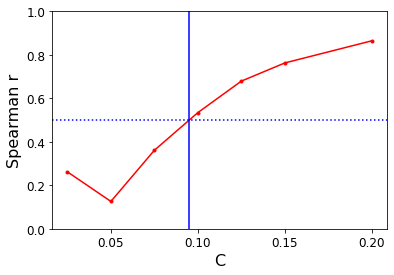

In [52]:
#Plots C vs Spearman r (correlation between ka and k2)

fig2, ax = plt.subplots(1)
ax.plot(C_options, rho_vector, '.r-') #'o', color='black')
ax.set_xlabel('C', fontsize=16)
ax.set_ylabel('Spearman r', fontsize=16)
#ax.set_title('%s scan' %name_group)
ax.set(ylim=(0.0, 1))
plt.rcParams['font.size'] = '16'
plt.axhline(y=0.5, color='b', linestyle='dotted')
plt.axvline(x=0.095, color='b', linestyle='solid') #Add ine to plot a vertical line
# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)
plt.show()
fig2.savefig('C vs Spearman r.png' , dpi=600)

## Confidence interval for ka

In [53]:

C_vector = []
ka_vector = []
k2_vector = []
AIC_vector = []

n=1000 #change here the number of random simulations
#print(n)

for i in range(0,n):
    x_values = np.array([0, 5, 15, 30, 60])
        
    selection = 0 #Select 1 to use real means, or 0 to use random integers based on normal distribution of time points
    if selection == 0:
        #In this section, the mean of all animals is entered per time point, together with the standard deviation
        t0 = 0 
        t5 = np.random.normal(0.038, 0.02)
        t15 = np.random.normal(0.048, 0.03)
        t30 = np.random.normal(0.034, 0.02)
        t60 = np.random.normal(0.010, 0.01)
        y_values = np.array([t0,t5, t15, t30, t60]) #random values following normal distribution
    else:
        y_values = np.array([0, 0.038, 0.048,0.034,0.010]) # real mean

    #Initial guess for parameters
    C_=0.095
    ka_=0.1
    k2_=0.01

   # set parameters including bounds; you can also fix parameters (use vary=False)
    params = Parameters()
    params.add('C', value=C_, vary = False) 
    params.add('ka', value=ka_, min = 0, max = np.inf) 
    params.add('k2', value=k2_, min = 0, max = np.inf) 

    result = minimize(residual, params, args=(x_values, y_values), method='leastsq') 

    show = 0 # show=0 do not show plots and report, show=1 show
    if show == 1:
        data_fitted = One_Elimination(np.linspace(0, 180, 181), result.params['C'].value,result.params['ka'].value,result.params['k2'].value)
        plt.figure()
        plt.scatter(x_values, y_values, marker='.', label='data')
        plt.plot(np.linspace(0, 180, 181), data_fitted, color = 'orange', label='fit')
        plt.xlabel('Time')
        plt.ylabel('Tracer')
        plt.legend()
        plt.show()
        print(fit_report(result))
    
    
    C_vector.append(result.params['C'].value)
    ka_vector.append(result.params['ka'].value)
    k2_vector.append(result.params['k2'].value)
    AIC_vector.append(result.aic)

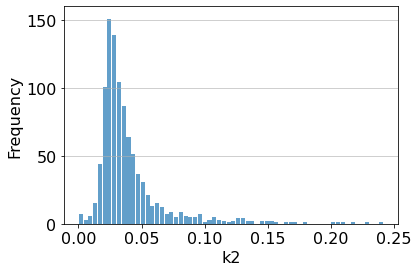

In [54]:
n, bins, patches = plt.hist(x=k2_vector, bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('k2', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(top=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10);

plt.savefig('k2 distribution.png', dpi=600, bbox_inches='tight');


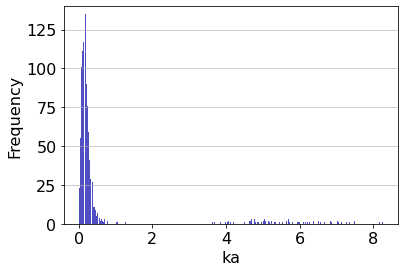

In [55]:
n, bins, patches = plt.hist(x=ka_vector, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('ka', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(top=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10);

plt.savefig('ka distribution_notfiltered.png', dpi=600, bbox_inches='tight');


In [56]:
#To filter values from ka vector that are higher than 1.0 (depends on the threshold to be selected)

ka_new = []
for i in range(len(ka_vector)):
    if ka_vector[i] < 1.0:
        ka_new.append(ka_vector[i])

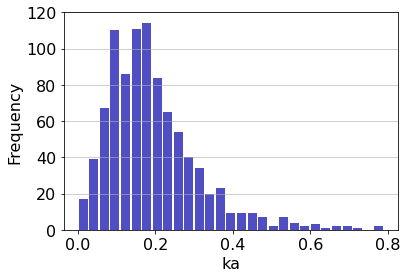

In [58]:
#Replots ka values histogram
n, bins, patches = plt.hist(x=ka_new, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('ka', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(top=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10);

plt.savefig('ka distribution.png', dpi=600, bbox_inches='tight');

In [59]:
#Returns the 95% CI of the median for ka and k2
print('k2 median:', round(np.median(k2_vector),3), ', 95%CI:', round(np.percentile(k2_vector,2.5),4), '-', round(np.percentile(k2_vector,97.5),4))
print('ka median:', round(np.median(ka_new),3), ', 95%CI:', round(np.percentile(ka_new,2.5),3), '-', round(np.percentile(ka_new,97.5),4))

k2 median: 0.031 , 95%CI: 0.0146 - 0.1282
ka median: 0.172 , 95%CI: 0.033 - 0.517
